In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import statistics
import kmax as kx
import utility as util
from hierarchy import *
from scipy.optimize import fsolve
from IPython.core.debugger import set_trace
import scipy.stats as stats
import pylab
import statsmodels.api as sm

In [2]:
def draw_tree(tree, layout, draw_path=True):
    rooted_tree = nx.bfs_tree(tree, 0)
    
    #nx.draw_networkx_nodes(tree, pos=layout, node_size=29)
    nx.draw_networkx_labels(tree, pos=layout, font_size=10, font_color="tab:blue")
    
    if draw_path:
        path_cover,_,X=util.path_cover(tree)
        nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=path_cover, edge_color="tab:red", arrows=True)
        
        other_edges = [(u,v) for u,v in rooted_tree.edges() if (u,v) not in path_cover and (v,u) not in path_cover]
        nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=other_edges)
    else:
        nx.draw_networkx_edges(rooted_tree, pos=layout)

# Simulations 3

## Goals:
- Find path segment length for a typical vertex

In [3]:
# Calculate the length of the path passing 
# through `node` in `path_cover`
def path_seg_length(tree, path_cover, node):
    if len(path_cover) == 0:
        return 0
    
    path_subgraph = tree.edge_subgraph(path_cover)
    if node not in path_subgraph:
        return 0

    # node_connected_component returns a list of nodes, so we subtract 1 to get the number of edges
    return len(nx.node_connected_component(path_subgraph, node)) - 1

def all_path_seg_lengths(tree):
    path_covers = {}
    for component in nx.connected_components(tree):
        component_root = list(component)[0]
        path_cover,_,_ = util.path_cover(tree, root=component_root)
        for node in component:
            path_covers[node] = path_cover
    
    return {node : path_seg_length(tree, path_covers[node], node) for node in tree.nodes()}

In [9]:
n = 20
lam = 0.7
#sample_tree = nx.fast_gnp_random_graph(n, lam/n)
sample_tree = nx.random_labeled_tree(n)
for u,v in sample_tree.edges():
    sample_tree[u][v]['weight'] = 1

print(all_path_seg_lengths(sample_tree))

{0: 5, 1: 2, 2: 6, 3: 6, 4: 2, 5: 2, 6: 6, 7: 5, 8: 2, 9: 6, 10: 0, 11: 6, 12: 2, 13: 2, 14: 6, 15: 6, 16: 5, 17: 5, 18: 5, 19: 5}


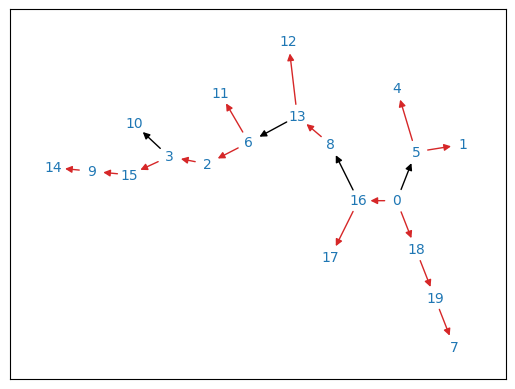

In [12]:
draw_tree(sample_tree, hierarchyc_pos(sample_tree, root=0))